In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)


In [24]:

df = pd.read_csv("ecommerce_customer_data_large.csv", low_memory=False)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'], errors='coerce')
df['year_month'] = df['Purchase Date'].dt.to_period('M').astype(str)
df['order_value'] = pd.to_numeric(df.get('Total Purchase Amount', df.get('Product Price', np.nan)), errors='coerce')
print("Rows, cols:", df.shape)
display(df.head())
display(df.info())
display(df[['Purchase Date','order_value']].describe())



Rows, cols: (250000, 15)


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn,year_month,order_value
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0,2023-05,2427
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0,2021-05,2448
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0,2020-07,2345
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0,2023-01,937
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0,2021-05,2598


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Customer ID            250000 non-null  int64         
 1   Purchase Date          250000 non-null  datetime64[ns]
 2   Product Category       250000 non-null  object        
 3   Product Price          250000 non-null  int64         
 4   Quantity               250000 non-null  int64         
 5   Total Purchase Amount  250000 non-null  int64         
 6   Payment Method         250000 non-null  object        
 7   Customer Age           250000 non-null  int64         
 8   Returns                202618 non-null  float64       
 9   Customer Name          250000 non-null  object        
 10  Age                    250000 non-null  int64         
 11  Gender                 250000 non-null  object        
 12  Churn                  250000 non-null  int6

None

,Purchase Date,order_value
count,250000,250000.000000
mean,2021-11-06 19:26:22.286192384,2725.385196
min,2020-01-01 00:07:26,100.000000
25%,2020-12-03 08:10:12,1476.000000
50%,2021-11-06 07:39:08.500000,2725.000000
75%,2022-10-11 01:21:56.249999872,3975.000000
max,2023-09-13 18:42:49,5350.000000
std,NaN,1442.576095


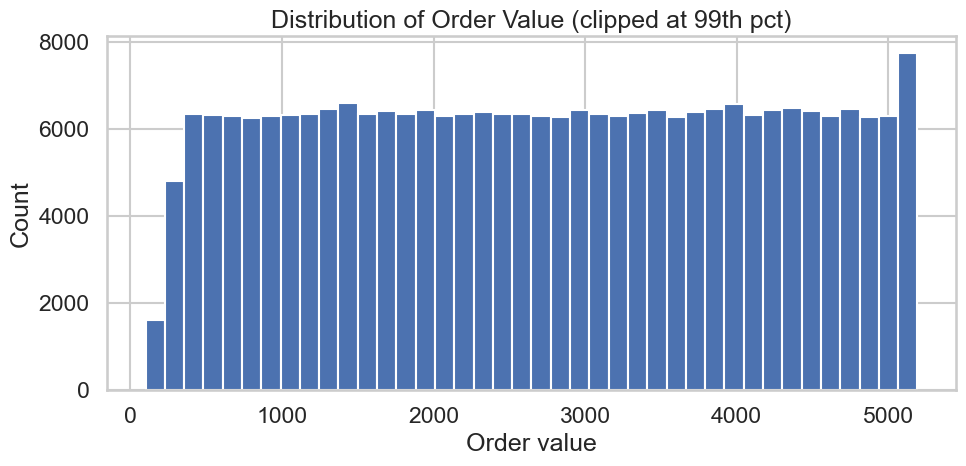

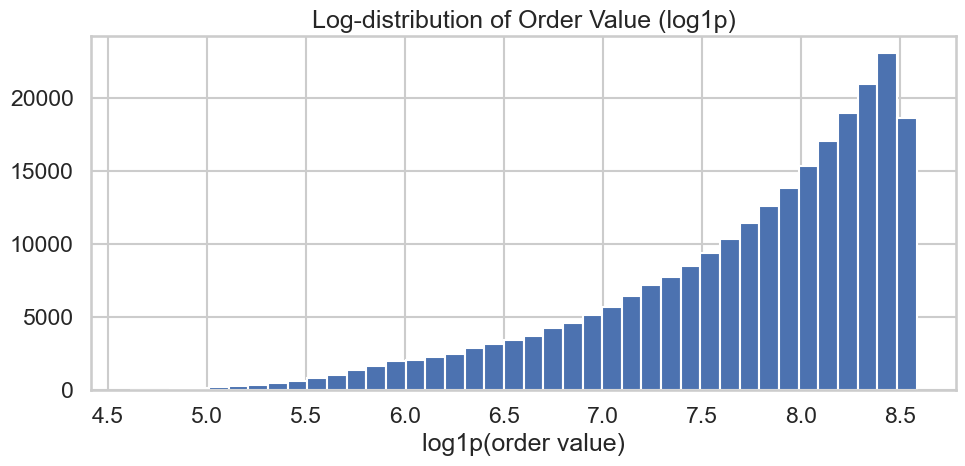

In [16]:
#  Histogram of order value
col = 'order_value'
vals = df[col].dropna()
clipped = vals.clip(upper=vals.quantile(0.99))  

plt.figure()
plt.hist(clipped, bins=40)
plt.title("Distribution of Order Value (clipped at 99th pct)")
plt.xlabel("Order value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# log scale
plt.figure()
plt.hist(vals[vals>0].apply(np.log1p), bins=40)
plt.title("Log-distribution of Order Value (log1p)")
plt.xlabel("log1p(order value)")
plt.tight_layout()
plt.show()


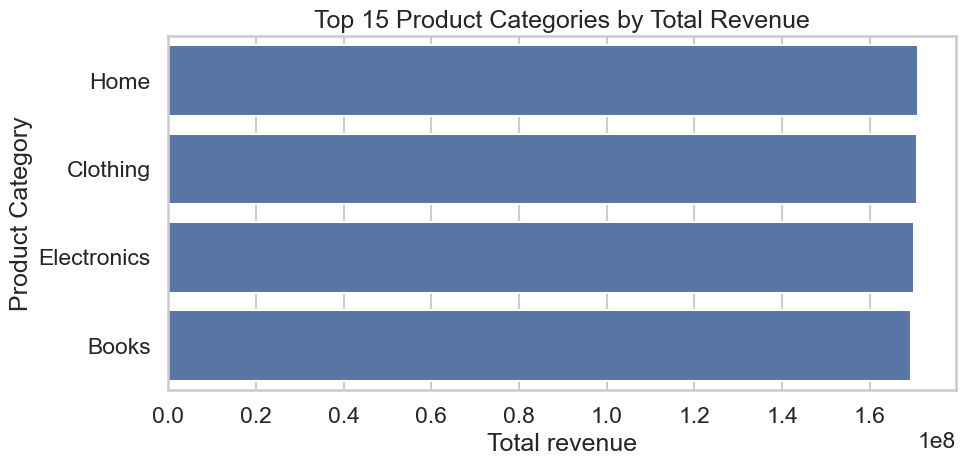

In [17]:
# Top product categories by total revenue
cat_col = 'Product Category'  
grouped = df.groupby(cat_col)['order_value'].sum().sort_values(ascending=False).head(15)
plt.figure()
sns.barplot(x=grouped.values, y=grouped.index)
plt.title("Top 15 Product Categories by Total Revenue")
plt.xlabel("Total revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


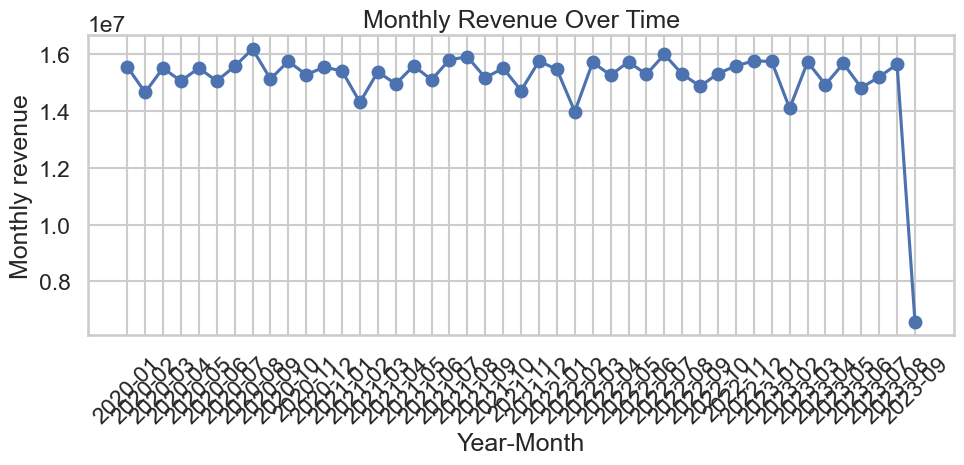

In [18]:
# Monthly revenue line chart
monthly = df.groupby('year_month')['order_value'].sum().reset_index()
plt.figure()
plt.plot(monthly['year_month'], monthly['order_value'], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Revenue Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Monthly revenue")
plt.tight_layout()
plt.show()


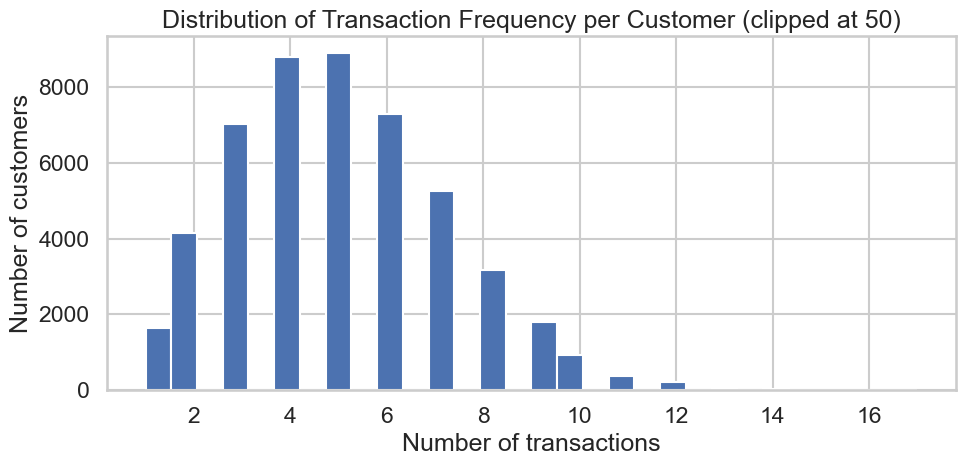

Customer ID
48382    17
8770     16
4200     16
13805    15
39895    15
25927    15
35294    15
32869    15
43126    15
12647    15
Name: frequency, dtype: int64

In [19]:
# Transactions per customer histogram
cust_col = 'Customer ID'
tx_counts = df.groupby(cust_col).size().rename('frequency')
plt.figure()
plt.hist(tx_counts.clip(upper=50), bins=30)  # clip to show common range
plt.title("Distribution of Transaction Frequency per Customer (clipped at 50)")
plt.xlabel("Number of transactions")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

# Top 10 frequent customers
display(tx_counts.sort_values(ascending=False).head(10))


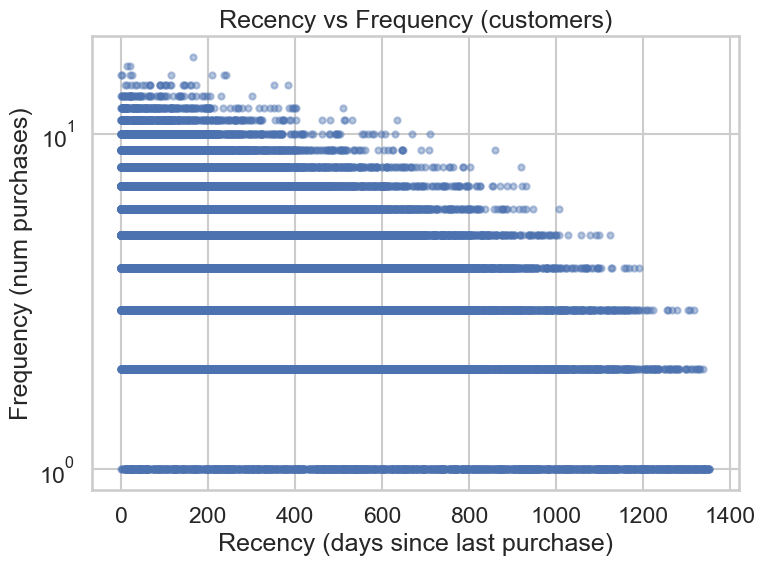

In [20]:
# Recency vs frequency
if 'rfm' not in globals():
    ref_date = df['Purchase Date'].max() + pd.Timedelta(days=1)
    last_purchase = df.groupby(cust_col)['Purchase Date'].max().rename('last_purchase')
    frequency = df.groupby(cust_col).size().rename('frequency')
    monetary = df.groupby(cust_col)['order_value'].sum().rename('monetary')
    rfm = pd.concat([last_purchase, frequency, monetary], axis=1).reset_index()
    rfm['recency'] = (ref_date - rfm['last_purchase']).dt.days

plt.figure(figsize=(8,6))
plt.scatter(rfm['recency'], rfm['frequency'], alpha=0.4, s=20)
plt.yscale('log')  # optional: use log for frequency
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (num purchases)')
plt.title('Recency vs Frequency (customers)')
plt.tight_layout()
plt.show()


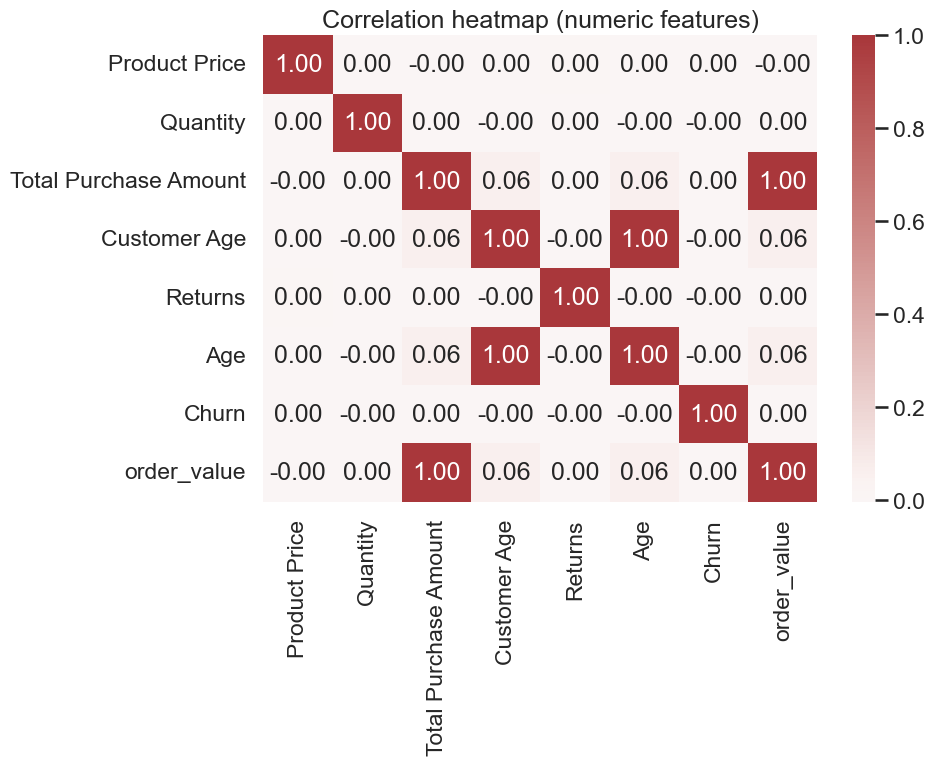

In [21]:
# Correlation heatmap for numeric columns
numeric = df.select_dtypes(include=['number']).copy()
numeric = numeric.drop(columns=[col for col in numeric.columns if 'id' in col.lower()], errors='ignore')

corr = numeric.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()


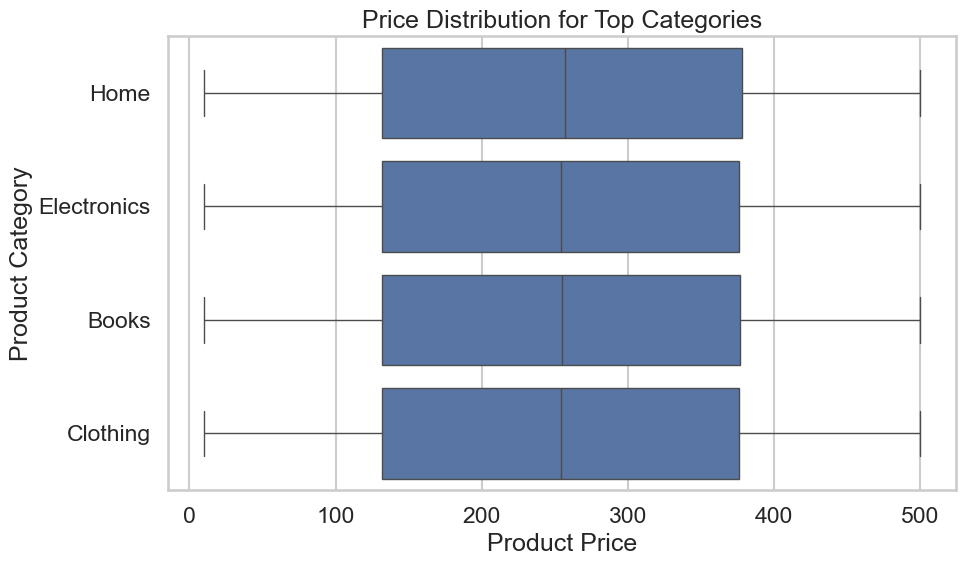

In [22]:
# Boxplot of product price across top N categories
price_col = 'Product Price'
top_cats = df.groupby(cat_col)[price_col].median().sort_values(ascending=False).head(8).index
plt.figure(figsize=(10,6))
sns.boxplot(y=cat_col, x=price_col, data=df[df[cat_col].isin(top_cats)])
plt.title("Price Distribution for Top Categories")
plt.tight_layout()
plt.show()


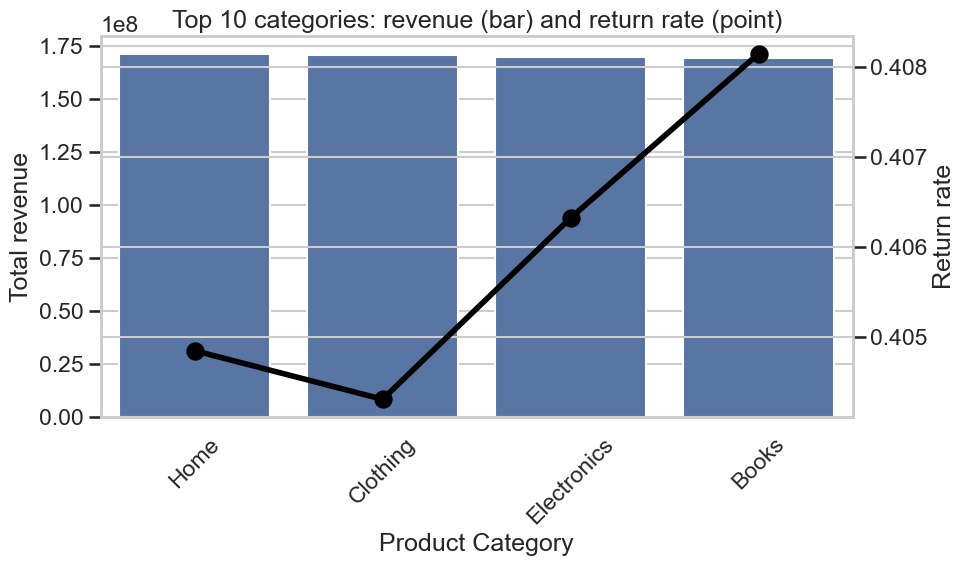

In [25]:
# Returns rate by category
if 'Returns' in df.columns:
    returns_summary = df.groupby(cat_col).agg(total_revenue=('order_value','sum'),
                                              returns_count=('Returns','sum'),
                                              orders=('order_value','count'))
    returns_summary['return_rate'] = returns_summary['returns_count'] / returns_summary['orders']
    top = returns_summary.sort_values('total_revenue', ascending=False).head(10)


    fig, ax1 = plt.subplots(figsize=(10,6))
    ax2 = ax1.twinx()
    sns.barplot(x=top.index, y='total_revenue', data=top, ax=ax1)
    sns.pointplot(x=top.index, y='return_rate', data=top, ax=ax2, color='black')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylabel("Total revenue")
    ax2.set_ylabel("Return rate")
    plt.title("Top 10 categories: revenue (bar) and return rate (point)")
    plt.tight_layout()
    plt.show()
